# Predicting Diatom concentration with functional regression based on the oceanographic boxes (spatial means) (Forecasts)

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression

from skfda.representation.grid import FDataGrid
from skfda.ml.clustering import KMeans

from skfda.misc.hat_matrix import LocalLinearRegressionHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

from skfda.ml.regression import HistoricalLinearRegression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

from tqdm import tqdm

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi


In [4]:
x = np.array(['Tom', 'Mike', 'Tiffany', 'Joel', 'Varada'])
x

array(['Tom', 'Mike', 'Tiffany', 'Joel', 'Varada'], dtype='<U7')

In [3]:
[name.upper() for name in x]

['TOM', 'MIKE', 'TIFFANY', 'JOEL', 'VARADA']

In [6]:
s = pd.Series(x)
s

0        Tom
1       Mike
2    Tiffany
3       Joel
4     Varada
dtype: object

In [14]:
from datetime import datetime, timedelta
date = datetime.strptime("July 9 2005, 13:54", "%B %d %Y, %H:%M")
date

datetime.datetime(2005, 7, 9, 13, 54)

In [27]:
dates = np.arange("2020-07", "2022-12", dtype='datetime64[M]')
dates

array(['2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11'],
      dtype='datetime64[M]')

In [28]:
index = [('Tom', 2019), ('Tom', 2020),
         ('Mike', 2019), ('Mike', 2020),
         ('Tiffany', 2019), ('Tiffany', 2020)]
courses = [4, 6, 5, 5, 6, 3]
s = pd.Series(courses, index)
s

(Tom, 2019)        4
(Tom, 2020)        6
(Mike, 2019)       5
(Mike, 2020)       5
(Tiffany, 2019)    6
(Tiffany, 2020)    3
dtype: int64

In [30]:
mi = pd.MultiIndex.from_tuples(index)
mi

MultiIndex([(    'Tom', 2019),
            (    'Tom', 2020),
            (   'Mike', 2019),
            (   'Mike', 2020),
            ('Tiffany', 2019),
            ('Tiffany', 2020)],
           )

In [34]:
s = pd.Series(courses, mi)
s

Tom      2019    4
         2020    6
Mike     2019    5
         2020    5
Tiffany  2019    6
         2020    3
dtype: int64

In [38]:
tom = pd.DataFrame({"Courses": [4, 6],
                    "Students": [273, 342]},
                    index = [2019, 2020])
mike = pd.DataFrame({"Courses": [5, 5],
                     "Students": [293, 420]},
                     index = [2019, 2020])
tiff = pd.DataFrame({"Courses": [6, 3],
                     "Students": [363, 190]},
                     index = [2019, 2020])

s3 = pd.concat((tom, mike, tiff),
               keys= ['Tom', 'Mike', 'Tiff'],
               axis=0)
s3

Courses  Students
Tom  2019        4       273
     2020        6       342
Mike 2019        5       293
     2020        5       420
Tiff 2019        6       363
     2020        3       190

In [43]:
s3.loc['Tom', 2019]['Courses']

np.int64(4)

In [ ]:
df2 = pd.DataFrame([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]],
             index = ["R1", "R2", "R3"],
             columns = ["C1", "C2", "C3"])
df2

In [155]:
df

,Name,Language,Courses
0,Tom,Python,5
1,Mike,Python,4
2,Tiffany,R,7


In [164]:
df3 = df.rename({'Name': 'Name3'}, axis=1)

In [181]:
df3.columns.names = ['J']

In [187]:
df3 = df3.rename(index={0:'One', 1:'Two', 2:'Three'})

In [189]:
df3['Rider'] = 'Tom Beuzen', 'Tom', 'Tim'

In [191]:
df = pd.DataFrame({"Name": ["Tom", "Mike", "Tiffany", "Varada", "Joel"],
                   "2018": [1, 3, 4, 5, 3],
                   "2019": [2, 4, 3, 2, 1],
                   "2020": [5, 2, 4, 4, 3]})
df

,Name,2018,2019,2020
0,Tom,1,2,5
1,Mike,3,4,2
2,Tiffany,4,3,4
3,Varada,5,2,4
4,Joel,3,1,3


In [197]:
df_melt = df.melt(id_vars="Name",
                  var_name="Year",
                  value_name="Courses")
df_melt

,Name,Year,Courses
0,Tom,2018,1
1,Mike,2018,3
2,Tiffany,2018,4
3,Varada,2018,5
4,Joel,2018,3
5,Tom,2019,2
6,Mike,2019,4
7,Tiffany,2019,3
8,Varada,2019,2
9,Joel,2019,1


In [46]:
df = pd.DataFrame([[np.nan, 2, np.nan, 0],
                   [3, 4, np.nan, 1],
                   [np.nan, np.nan, np.nan, 5],
                   [np.nan, 3, np.nan, 4]],
                  columns=list('ABCD'))
df

,A,B,C,D
0,NaN,2.0,NaN,0
1,3.0,4.0,NaN,1
2,NaN,NaN,NaN,5
3,NaN,3.0,NaN,4


<Axes: >

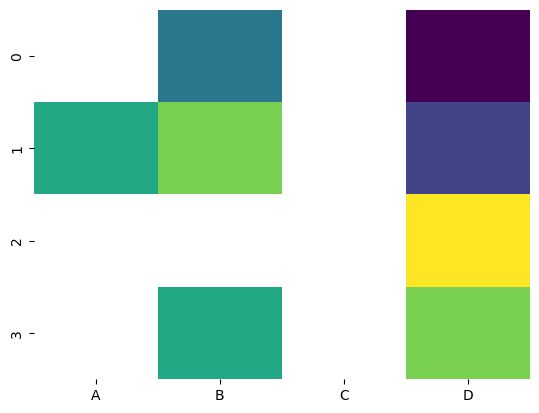

In [49]:
import seaborn as sns

sns.heatmap(df, cmap='viridis', cbar=False)

In [ ]:
test = df.groupby(['Name', 'Year']).sum()
test = test.drop(columns='Department')
test

Courses
Name Year         
Mike 2018        4
     2019        6
     2020        4
Tom  2018        3
     2019        5
     2020        6

In [27]:
test = test.unstack()

In [28]:
test

Courses          
Year    2018 2019 2020
Name                  
Mike       4    6    4
Tom        3    5    6

In [19]:
test = test.reset_index()
test.columns.name = None
test

,Name,Year,Courses
0,Mike,2018,4
1,Mike,2019,6
2,Mike,2020,4
3,Tom,2018,3
4,Tom,2019,5
5,Tom,2020,6


In [20]:
test.columns

Index(['Name', 'Year', 'Courses'], dtype='object')

In [21]:
test.pivot(index='Name', columns='Year')

Courses          
Year    2018 2019 2020
Name                  
Mike       4    6    4
Tom        3    5    6

In [23]:
df.pivot_table(index="Name", columns='Year', values='Courses', aggfunc='sum')

Year,2018,2019,2020
Name,,,
Mike,4,6,4
Tom,3,5,6


## Initiation

In [18]:
name = 'Diatom'
units = '[mmol / $m^2$]'
category = 'biomasses'

path = '/data/ibougoudis/MOAD/files/forecasts/'
files = sorted(os.listdir(path))
files_all = xr.open_mfdataset(path+'*.nc')

# Time index
jan_apr_i = ((files_all.time_counter.dt.month == 1) | (files_all.time_counter.dt.month == 2) | (files_all.time_counter.dt.month == 3) | (files_all.time_counter.dt.month == 4))

ds = files_all.where(jan_apr_i, drop=True)

inputs_names = [['Net Shortwave Surface Radiation', 'Liquid Water Equivalent Thickness of Total Precipitation Amount'], 
    ['Net Shortwave Surface Radiation'], 
    ['Net Shortwave Surface Radiation', 'Liquid Water Equivalent Thickness of Total Precipitation Amount'],
    ['Net Shortwave Surface Radiation', 'Liquid Water Equivalent Thickness of Total Precipitation Amount'], 
    ['Net Shortwave Surface Radiation', 'Net Longwave Surface Radiation'], 
    ['Net Shortwave Surface Radiation', 'Near-Surface Air Temperature'], 
    ['Net Shortwave Surface Radiation', 'Near-Surface Air Temperature'], 
    ['Net Shortwave Surface Radiation'], 
    ['Net Shortwave Surface Radiation', 'Net Longwave Surface Radiation']]

unique_inputs_names = []
for i in inputs_names:
    unique_inputs_names.extend(i)
unique_inputs_names = list(set(unique_inputs_names))

n_intervals = 4
lags = [29.75, 29.75, 29.75, 29.75, 29.75, 29.75, 29.75, 29.75, 29.75]
period = '(01 Jan - 30 Apr)'
id = '2'

ds = ds.sel(member=0) # inputs

ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/inputs/jan_apr.nc', chunks={'time_counter': 30, 'y': 150, 'x': 67})
ds2 = ds2.sel(time_counter=slice('2007', '2024'))

ds2 = ds2[['Summation_of_solar_radiation', 'Summation_of_longwave_radiation', 'Mean_pressure', 'Mean_air_temperature', 
    'Mean_precipitation', 'Mean_wind_speed']]


/tmp/ipykernel_966190/1251349471.py:36: UserWarning: The specified chunks separate the stored chunks along dimension "time_counter" starting at index 30. This could degrade performance. Instead, consider rechunking after loading.
  ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/inputs/jan_apr.nc', chunks={'time_counter': 30, 'y': 150, 'x': 67})
/tmp/ipykernel_966190/1251349471.py:36: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 150. This could degrade performance. Instead, consider rechunking after loading.
  ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/inputs/jan_apr.nc', chunks={'time_counter': 30, 'y': 150, 'x': 67})
/tmp/ipykernel_966190/1251349471.py:36: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 67. This could degrade performance. Instead, consider rechunking after loading.
  ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/inputs/jan_apr.nc', chunks={'time_co

In [19]:
test = ds['Liquid Water Equivalent Thickness of Total Precipitation Amount']

In [28]:
a = test.groupby(test.time_counter.dt.year)

In [30]:
a

<DataArrayGroupBy, grouped over 1 grouper(s), 18 groups in total:
    'year': UniqueGrouper('year'), 18/18 groups with labels 2007, 2008, 2009, ..., 2023, 2024>

In [35]:
a.groupers[2007]

IndexError: tuple index out of range

In [120]:
test.shape

(898, 398)

In [ ]:
test3 = test.query(y = 'y' > z, x = 'x > 50')

In [ ]:
test3

In [ ]:
test2 = test.where(((test.y > z) & (test.x > 50)), drop=True)

In [ ]:
test2

In [ ]:
dataset = ds.where(((ds.time_counter.dt.day>24) & (ds.time_counter.dt.month==3)) | ((ds.time_counter.dt.day<6) & (ds.time_counter.dt.month==4)), drop=True)
dataset = dataset.mean(['y','x'])
dataset = dataset.groupby(dataset.time_counter.dt.year).sum()

dataset2 = ds2.where(((ds2.time_counter.dt.day>24) & (ds2.time_counter.dt.month==3)) | ((ds2.time_counter.dt.day<6) & (ds2.time_counter.dt.month==4)), drop=True)
dataset2 = dataset2.mean(['y','x'])
dataset2 = dataset2.groupby(dataset2.time_counter.dt.year).sum()

In [ ]:
dataset['Net Shortwave Surface Radiation'].to_numpy()

In [ ]:
print('correlation for short-wave solar radiation: ' + str(xr.corr(dataset['Net Shortwave Surface Radiation'],dataset2['Summation_of_solar_radiation']).values))
print('correlation for long-wave solar radiation: ' + str(xr.corr(dataset['Net Longwave Surface Radiation'],dataset2['Summation_of_longwave_radiation']).values))
print('correlation for mean pressure: ' + str(xr.corr(dataset['Sea Level Pressure'],dataset2['Mean_pressure']).values))
print('correlation for mean precipitation: ' + str(xr.corr(dataset['Liquid Water Equivalent Thickness of Total Precipitation Amount'],dataset2['Mean_precipitation']).values))
print('correlation for mean air temperature: ' + str(xr.corr(dataset['Mean_wind_speed'],dataset2['Mean_wind_speed']).values))